# I.  Project Overview

<center><img src="resources/preview.jpg" width="700"></center>

In this project, we will create a simple classifier that determines: CHIHUAHUA… or MUFFIN!

First, let's see what we will cover in this tutorial!

* Review of Machine Learning pipeline, Deep Learning and neurual networks
* Start Deep Learning 
    * Build the model
    * Load the dataset
    * Create train loop (building our model)
    * Save the model
* Test the result

### Remember: This is an INTERACTIVE Notebook!
You should run code cells and play with code as you go to see how the code works.
<img src="resources/jupyter_animated.gif" width="700">

# III.  Deep Learning Tutorial

<center><img src="resources/Pytorch_logo.png" width="700"></center>

**Generic Python imports** (select the below cell and press shift-enter to execute it)

In [1]:
import matplotlib.pyplot as plt  # graphical library, to plot images
# special Jupyter notebook command to show plots inline instead of in a new window
%matplotlib inline

**Deep learning imports**

In [2]:
import torch                                            # PyTorch deep learning framework
from torchvision import datasets, models, transforms    # extension to PyTorch for dataset management
import torch.nn as nn                                   # neural networks module of PyTorch, to let us define neural network layers
from torch.nn import functional as F                    # special functions
import torch.optim as optim                             # optimizers


## (1) Build our Neural Network

<center><img src="resources/what_is_nn_slide.jpg" width="700"></center>

In [3]:
from functools import reduce

class MySkynet(nn.Module):
    def __init__(self, input_dim=(3, 224, 224)):
        super().__init__()
        num_in_features = reduce(lambda x,y: x * y, input_dim)
        self.layer_1 = nn.Linear(num_in_features, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_3 = nn.Linear(64, 2)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        
        x = F.softmax(x)
        
        return x

**Choose neural network architecture**

In [4]:
 # cuda:0 means the first cuda device found
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = MySkynet().to(device)                      # load our simple neural network

##### Define the loss function and optimizer for training

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0002)


## (2) Data and Data Loading

### Separate "train" and "test" datasets

Recall from the below slide, we should make two separate datasets to train and test our model. That way, we know our model learns more than rote memorization.

<center><img src="resources/when_is_your_model_ready_slide.jpg" width="600"></center>

### Inspect our data
Let's look in our data folder to see what's there. As you can see, the folder is **split into "train" for training**, and **"validation" for testing** (to validate our model).

(select the below cell and press shift-enter to execute it)

In [6]:
import os  # interact with the os. in our case, we want to view the file system

print("Data contents:", os.listdir("data"))
print("Train contents:", os.listdir("data/train"))
print("Validation contents:", os.listdir("data/validation"))

Data contents: ['validation', 'train']
Train contents: ['chihuahua', 'muffin']
Validation contents: ['chihuahua', 'muffin']


Let's also look at some of the images:

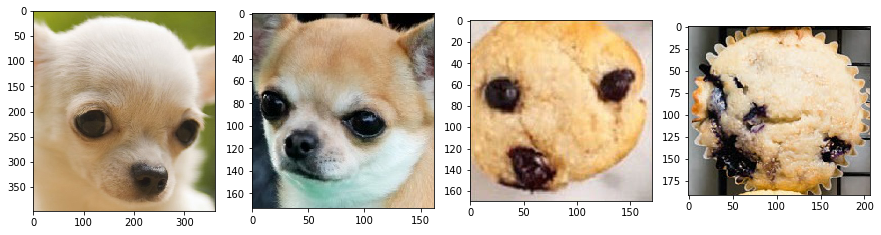

In [7]:
from PIL import Image  # import our image opening tool

_, ax = plt.subplots(1, 4, figsize=(15,60))  # to show 4 images side by side, make a "1 row x 4 column" axes
ax[0].imshow(Image.open("data/train/chihuahua/4.jpg"))  # show the chihuahua in the first column
ax[1].imshow(Image.open("data/train/chihuahua/5.jpg"))  # show the chihuahua in the second column
ax[2].imshow(Image.open("data/train/muffin/131.jpg"))   # show the muffin in the third column
ax[3].imshow(Image.open("data/train/muffin/107.jpg"))   # show the muffin in the fourth column


We can also see how many images are in train, and how many are in validation:

If you look in the data folder on your computer, there are 120 train images and 30 validation, our data is split like this:
<img src="resources/folders.png" width="600">

### Load our data

That's great that we have data! But we have to load all the images and convert them into a form that our neural network understands. Specifically, PyTorch works with **Tensor** objects. (A tensor is just a multidimensional matrix, i.e. an N-d array.)

<img src="resources/image_to_tensor.jpg" width="550">


**To easily convert our image data into tensors, we use the help of a "dataloader."** The dataloader packages data into nice boxes for our model to use. You can think of it like one person passing boxes (tensors) to another.
<img src="resources/dataloader_box_analogy.jpg" width="400">

**First, we define some "transforms" to convert images to tensors.** We must do so for both our train and validation datasets.

For more information about transforms, check out the link here: https://pytorch.org/docs/stable/torchvision/transforms.html

In [9]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

# transforms for our training data
train_transforms = transforms.Compose([
    # resize to resnet input size
    transforms.Resize((224,224)),
    # transform image to PyTorch tensor object
    transforms.ToTensor(),
    normalize
])

# these validation transforms are exactly the same as our train transforms
validation_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

print("Train transforms:", train_transforms)

Train transforms: Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


**Second, we create the datasets, by passing the transforms into the ImageFolder constructor:**

In [10]:
image_datasets = {
    'train':
        datasets.ImageFolder('data/train', train_transforms),
    'validation':
        datasets.ImageFolder('data/validation', validation_transforms)}

print("==Train Dataset Object==\n", image_datasets["train"])
print()
print("==Validation Dataset Object==\n", image_datasets["train"])

==Train Dataset Object==
 Dataset ImageFolder
    Number of datapoints: 120
    Root Location: data/train
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                         )
    Target Transforms (if any): None

==Validation Dataset Object==
 Dataset ImageFolder
    Number of datapoints: 120
    Root Location: data/train
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                         )
    Target Transforms (if any): None


**And finally, form dataloaders from the datasets:**

In [11]:
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=32,
            shuffle=True,
            num_workers=4),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=32,
            shuffle=False,
            num_workers=4)}

print("Train loader:", dataloaders["train"])
print("Validation loader:", dataloaders["validation"])

Train loader: <torch.utils.data.dataloader.DataLoader object at 0x7fb377e91eb8>
Validation loader: <torch.utils.data.dataloader.DataLoader object at 0x7fb377e916d8>


## (4) Train the model!

In [12]:
from tqdm import tnrange, tqdm_notebook # import progress bars to show train progress

def train_model(model, criterion, optimizer, num_epochs=3):
    """
    Trains a given model using the given criterion and optimizer, for a certain number of epochs.
    
    model: a PyTorch neural network
    criterion: a mathematical function that takes predictions and labels and returns a loss
    num_epochs: the number of times to run through the training dataset
    """
    # train for x epochs. an epoch is a full iteration through our dataset
    for epoch in tnrange(num_epochs, desc="Total progress", unit="epoch"):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # first train over the dataset and update weights; then after that train step, calculate our validation loss
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # keep track of the overall loss for this batch
            running_loss = 0.0
            running_corrects = 0

            # iterate through the inputs and labels in our dataloader
            # (the tqdm_notebook part is to display a progress bar)
            for inputs, labels in tqdm_notebook(dataloaders[phase], desc=phase, unit="batch", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f'{phase} error: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')

        print()

    return model

<center><img src="resources/gradient_descent.gif" width="700"></center>

#### run the train function

In [13]:
model = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------


/home/andrew/.conda/envs/mlclub/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train error: 0.6890, acc: 0.6833


validation error: 0.6880, acc: 0.7000

Epoch 2/3
----------


train error: 0.6876, acc: 0.6833


validation error: 0.6868, acc: 0.7000

Epoch 3/3
----------


train error: 0.6862, acc: 0.6917


validation error: 0.6858, acc: 0.7333




## Examine model performance

<img src="resources/question_mark.jpg" width="200" >

Choose some images

In [ ]:
import os
from glob import glob

validation_img_paths = glob("data/validation/**/*.jpg", recursive=True)
validation_img_paths

Calculate the prediction probabilities

In [ ]:
img_list = [Image.open(img_path) for img_path in validation_img_paths]
validation_batch = torch.stack( [validation_transforms(img).to(device) for img in img_list] )

# get the probability outputs from the model
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

Plot the images

In [ ]:
from math import floor # import a flooring function, e.g. 1.7 -> 1

fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, img in enumerate(img_list):
    ax = axs[floor(i/5)][i % 5]
    ax.axis('off')
    ax.set_title("{:.0f}% Chi, {:.0f}% Muff".format(100*pred_probs[i,0], 100*pred_probs[i,1]), fontsize=18)
    ax.imshow(img)


### Congratulations! You've successfully trained a neural network!

# Challenge

Now that we've shown you how to train a neural network, can you improve the validation accuracy by tweaking the parameters? We challenge you to reach 100%!

Some parameters to play with:
- Number of epochs
- The learning rate "lr" parameter in the optimizer
- Number of layers
- Data augmentation transforms https://pytorch.org/docs/stable/torchvision/transforms.html

# Credits

Credit for the original code base goes to https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/! We've modified it to fit this workshop.